In [3]:
include("../stage_1_optimization/stage_1_optimization.jl")
include("../stage_1_optimization/stage_1_data_processing.jl")
include("../path_generation/path_generation.jl");
include("../path_generation/path_generation_data_processing.jl")
include("../stage_2_optimization/stage_2_optimization.jl");

Academic license - for non-commercial use only


In [4]:
# File paths
NODES_FILE_PATH = "../data/paranagua_nodes_v2.csv"
EDGES_FILE_PATH = "../data/paranagua_edges_index.csv"
DELIVERIES_FILE_PATH = "../data/example_schedule_deliveries.csv"
PICKUPS_FILE_PATH = "../data/example_schedule_pickups.csv";

In [5]:
# Get node coordinates and edges
node_coords = convert(Matrix, CSV.read(NODES_FILE_PATH, header = true))
edge_indices = convert(Matrix, CSV.read(EDGES_FILE_PATH, header = true))[:,2:3]
distance_matrix = EuclDist(node_coords[:,2:3], node_coords[:,2:3]) .* AdjMat(edge_indices, size(node_coords,1))

# Get node balances from example schedule
node_balances = get_node_balances_from_schedule(DELIVERIES_FILE_PATH, PICKUPS_FILE_PATH)

# Get cost matrix for terminals in example schedule
cost_matrix = get_cost_matrix(NODES_FILE_PATH, EDGES_FILE_PATH, DELIVERIES_FILE_PATH)

# Get location and commodity names from example schedule (for plotting)
terminal_names, commodity_names = get_terminal_and_commodity_names_from_schedule(DELIVERIES_FILE_PATH)

# Set other problem parameters
max_capacity = 100
num_locomotives = 6;

In [6]:
# Stage 1 optimization
routes = optimize_routes(node_balances, cost_matrix, num_locomotives, max_capacity, λ=1);

Optimizing...
Objective value: 1428.0
Objective bound: 1428.0
MIP gap: 0.0
Time elapsed: 7.6s
All validation checks passed.


In [7]:
# Hack to fix minor bug in path generation code 
function process_path(path)
    return path[findall([node.name for node in path] .== path[1].name)[end]:end]
end

process_path (generic function with 1 method)

In [9]:
# Stage 2 optimization
K = 5
selected_paths = []
all_paths = []
for (from_nodes, to_nodes) in process_routes_for_stage_2(routes)
    sources = [findall(node_coords[:, 1] .== terminal_names[i])[1] for i in from_nodes]
    sinks = [findall(node_coords[:, 1] .== terminal_names[i])[1] for i in to_nodes]
    paths  = @suppress K_ShortestPaths(K, node_coords, edge_indices, distance_matrix, 
        sources, sinks, false)
    for l=1:num_locomotives   
        paths[l] = process_path.(paths[l])
    end
    push!(selected_paths, [paths[i][k] for (i, k) in sort(optimise_paths(paths))])
    push!(all_paths, paths)
end

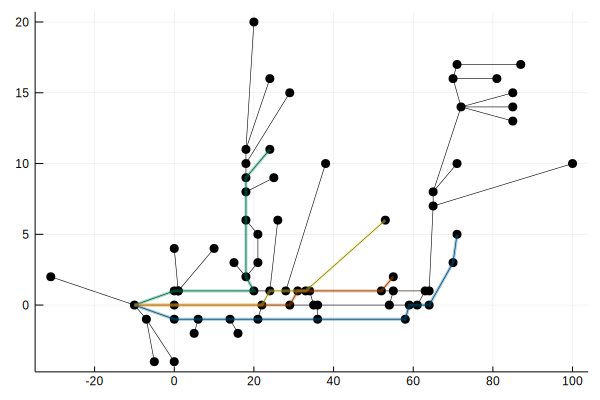

In [18]:
# Visualize selected paths for specified timestep
t = 2
paths = selected_paths[t]
gr()
P = PlotInitialGraph(node_coords, edge_indices)
for l=1:num_locomotives
    P = plotPath(P, paths[l])
end
plot(P)

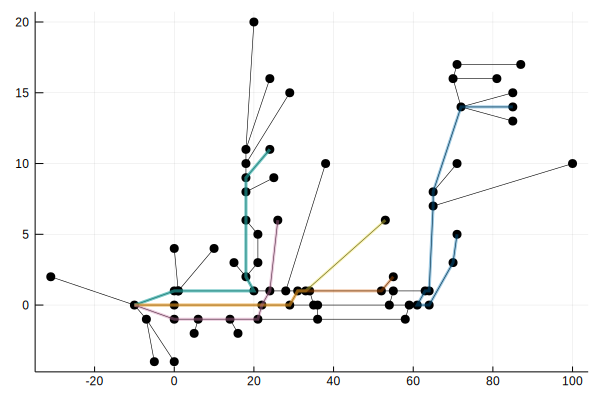

In [19]:
# Visualize selected paths for specified timestep
t = 3
paths = selected_paths[t]
gr()
P = PlotInitialGraph(node_coords, edge_indices)
for l=1:num_locomotives
    P = plotPath(P, paths[l])
end
plot(P)

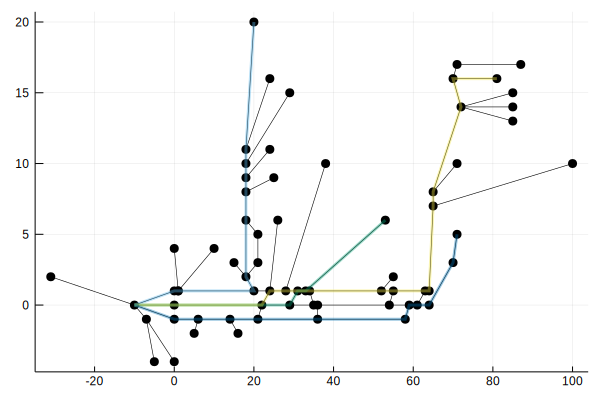

In [22]:
# Visualize selected paths for specified timestep
t = 7
paths = selected_paths[t]
gr()
P = PlotInitialGraph(node_coords, edge_indices)
for l=1:num_locomotives
    P = plotPath(P, paths[l])
end
plot(P)